<a href="https://colab.research.google.com/github/gabmachado97/jetson_segmentation/blob/main/resnet18_RoadSurfaceSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Road surface detection and differentiation considering surface damages

## 1. Initial settings

---



In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!/opt/bin/nvidia-smi
!nvcc --version

Sat Mar 20 21:36:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from fastai.vision import *
from fastai.vision.interpret import *
from fastai.callbacks.hooks import *
from pathlib import Path
from fastai.utils.mem import *
torch.backends.cudnn.benchmark=True
torch.set_printoptions(profile="full")

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 2. Preparing the data

---



In [ ]:
path = Path('/content/gdrive/My Drive/Mestrado/Segmentação/data/')
path.ls()

[PosixPath('/content/gdrive/My Drive/Mestrado/Segmentação/data/valid.txt'),
 PosixPath('/content/gdrive/My Drive/Mestrado/Segmentação/data/codes.txt'),
 PosixPath('/content/gdrive/My Drive/Mestrado/Segmentação/data/images'),
 PosixPath('/content/gdrive/My Drive/Mestrado/Segmentação/data/labels'),
 PosixPath('/content/gdrive/My Drive/Mestrado/Segmentação/data/results'),
 PosixPath('/content/gdrive/My Drive/Mestrado/Segmentação/data/colorLabels'),
 PosixPath('/content/gdrive/My Drive/Mestrado/Segmentação/data/results_color')]

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['background', 'roadAsphalt', 'roadPaved', 'roadUnpaved', 'roadMarking', 'speedBump', 'catsEye', 'stormDrain',
       'manholeCover', 'patchs', 'waterPuddle', 'pothole', 'craks'], dtype='<U12')

In [ ]:
path_lbl = path/'labels'
path_img = path/'images'

In [ ]:
fnames = get_image_files(path_img)
fnames[:3]
len(fnames)

732

In [ ]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]
len(lbl_names)

732

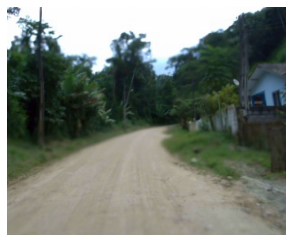

In [ ]:
img_f = fnames[139]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

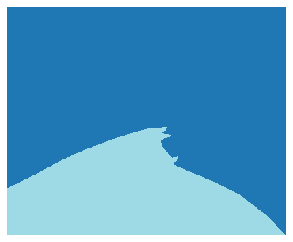

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

## 3. First Step - Without weights

---



### 3.1. First step Datasets

---



In [ ]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 15106MB of GPU RAM free


In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

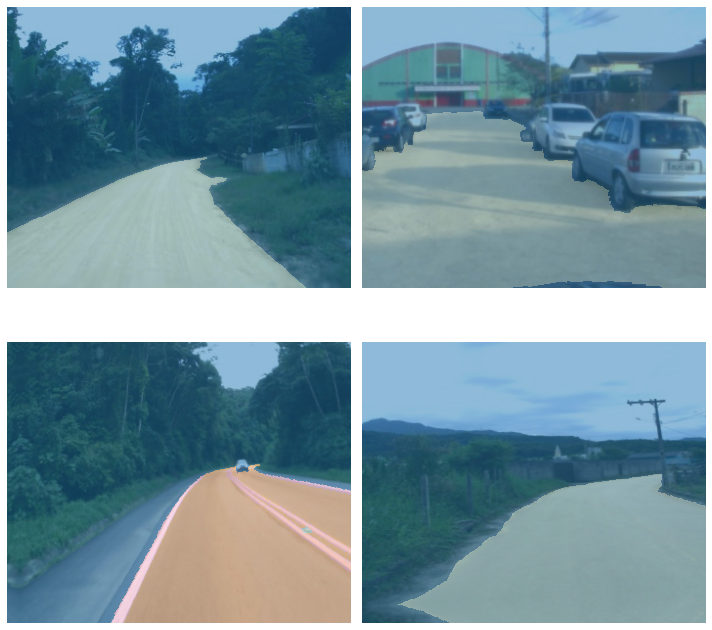

In [ ]:
data.show_batch(2, figsize=(10,10))

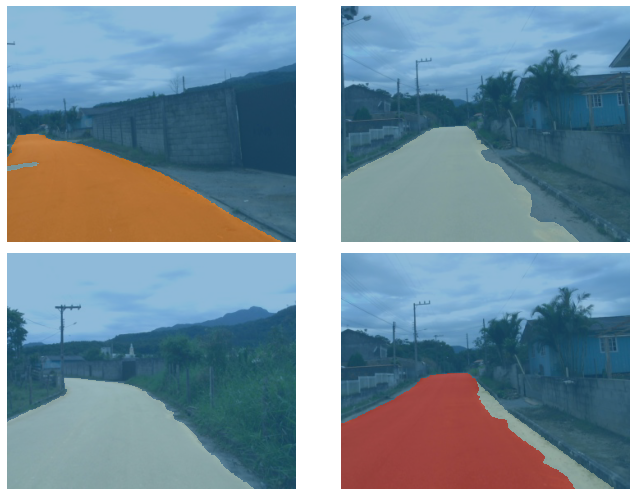

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### 3.2. First step Model

---



In [ ]:
name2id = {v:k for k,v in enumerate(codes)}

def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_rtk
wd=1e-2

In [ ]:
learn = unet_learner(data, models.resnet18, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


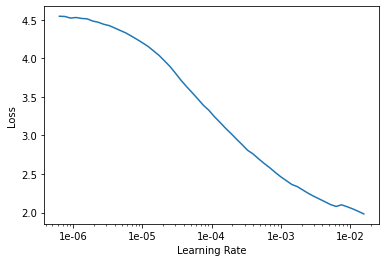

In [ ]:
#CUDA_LAUNCH_BLOCKING=1
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-4

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

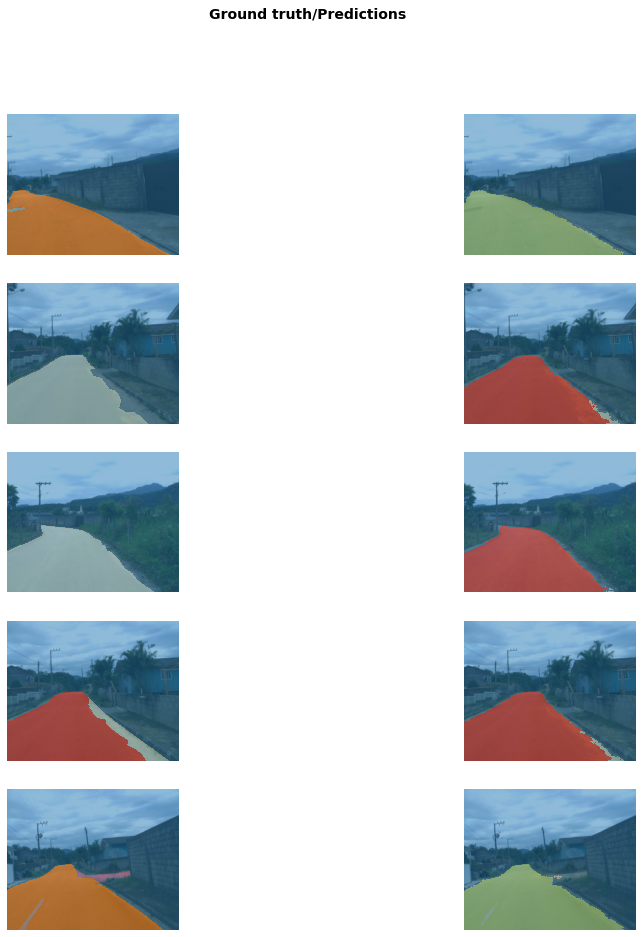

In [ ]:
learn.show_results(rows=5, figsize=(15,15))

### 3.3. Interpret

---



In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
top_losses, top_idxs = interp.top_losses((288,352))

(array([41., 26., 19., 10., 10.,  6.,  4.,  5.,  4.,  1.,  3.,  3.,  0.,  2.,  2.,  2.,  1.,  0.,  0.,  1.]),
 array([0.016768, 0.048241, 0.079714, 0.111187, 0.14266 , 0.174133, 0.205606, 0.237079, 0.268552, 0.300025, 0.331499,
        0.362972, 0.394445, 0.425918, 0.457391, 0.488864, 0.520337, 0.55181 , 0.583283, 0.614756, 0.646229],
       dtype=float32),
 <a list of 20 Patch objects>)

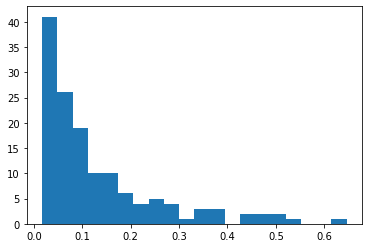

In [ ]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

In [ ]:
# top loss idxs of images
top_idxs[:5]

tensor([67, 60, 68, 55, 93])

### 3.4. Confusion Matrix

---



In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

((13, 13), (140, 13, 13))

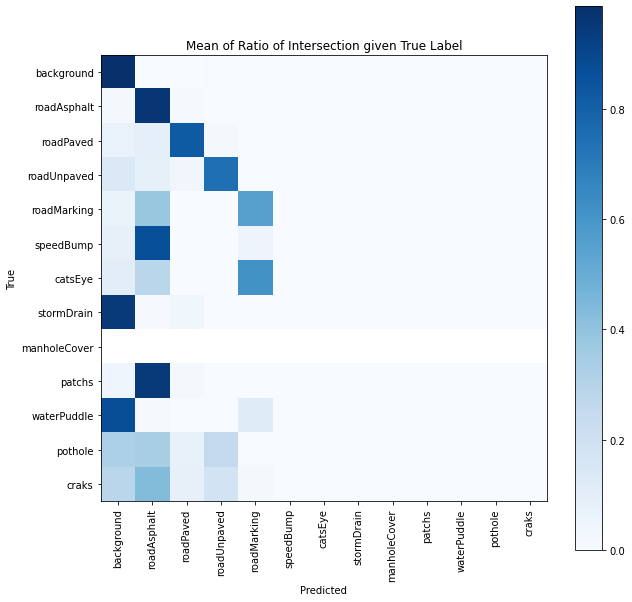

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

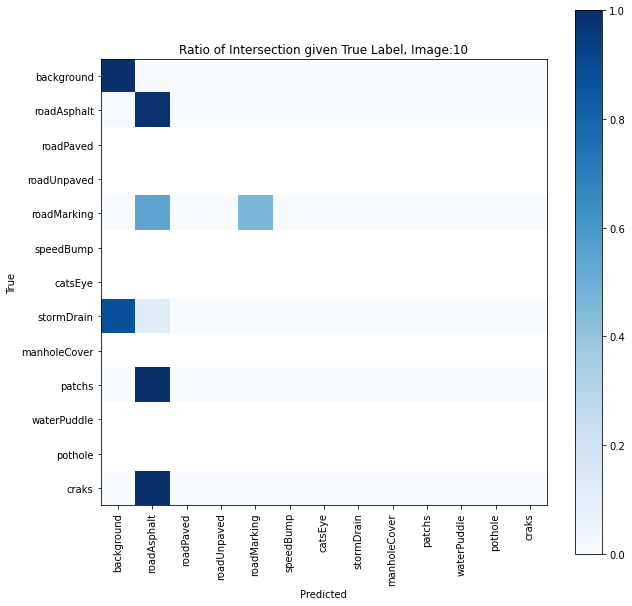

In [ ]:
# single image class performance
i = 10
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

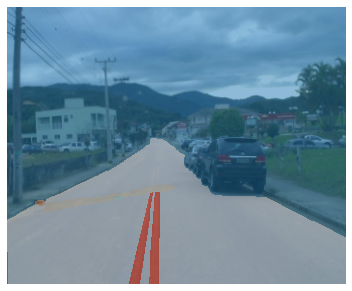

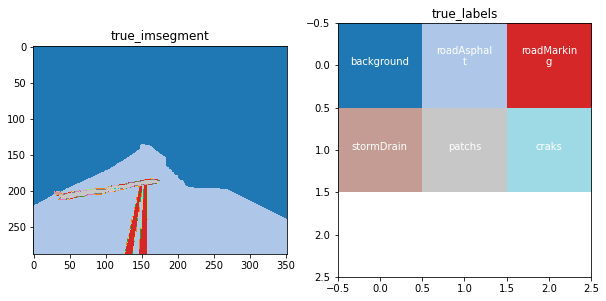

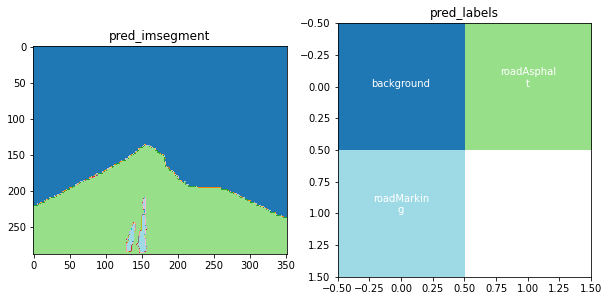

In [ ]:
# show xyz
interp.show_xyz(i)

### 3.5. First model continuation

---



In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(100, lrs, pct_start=0.9)

In [ ]:
learn.save('stage-2')

In [ ]:
learn.load('stage-2');

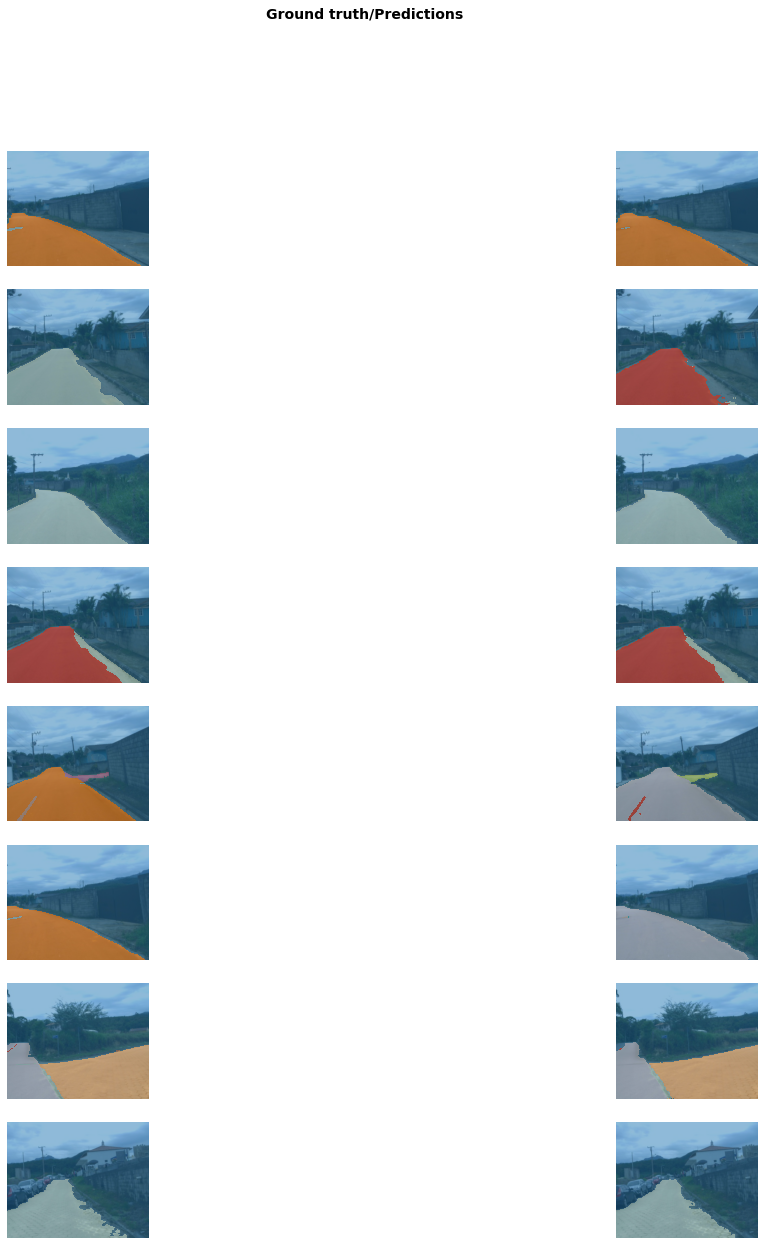

In [ ]:
learn.show_results(rows=25, figsize=(20,20))

### 3.6. Confusion Matrix

---



In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

((13, 13), (140, 13, 13))

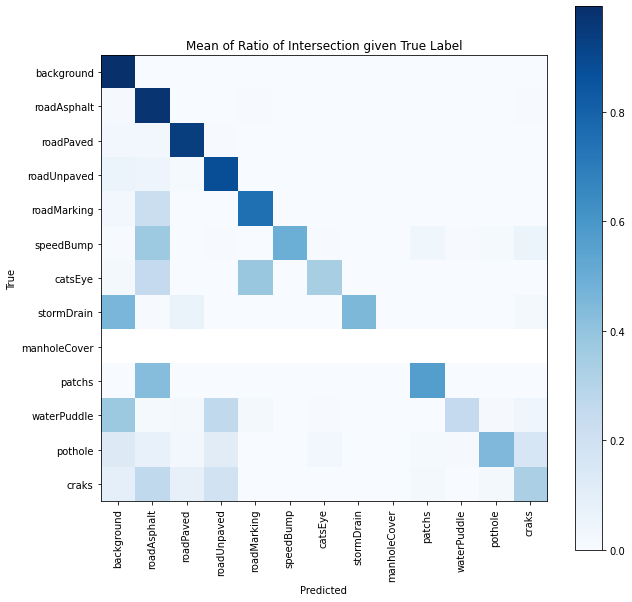

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

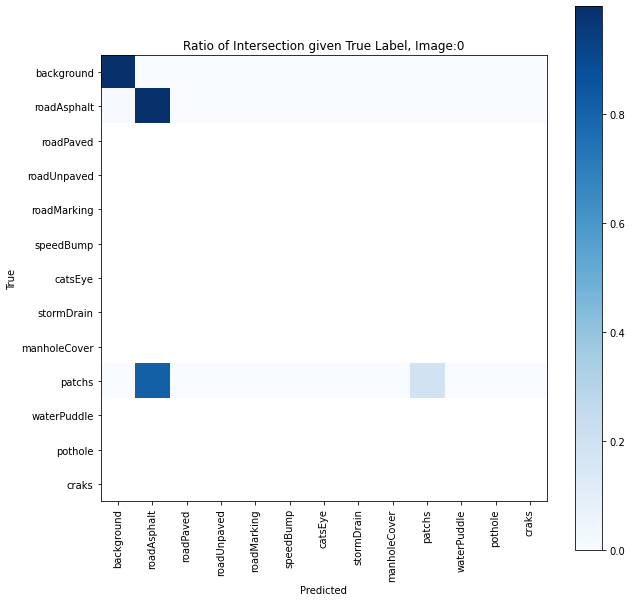

In [ ]:
# single image class performance
i = 0
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

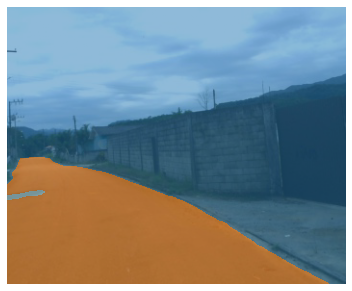

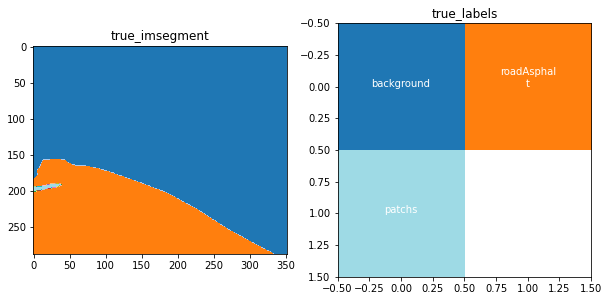

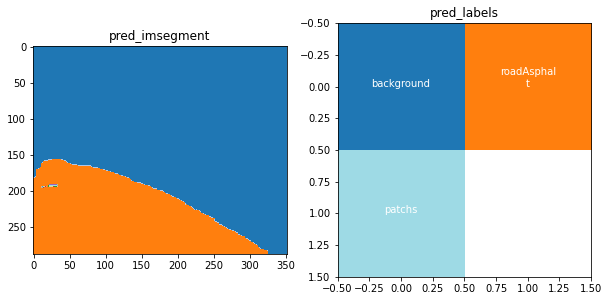

In [ ]:
# show xyz
interp.show_xyz(i)

### 3.7. Interpret

---



In [ ]:
learn.interpret

<bound method _learner_interpret of Learner(data=ImageDataBunch;

Train: LabelList (592 items)
x: SegmentationItemList
Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352)
y: SegmentationLabelList
ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352)
Path: /content/gdrive/My Drive/Mestrado/Segmentação/data/images;

Valid: LabelList (140 items)
x: SegmentationItemList
Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352)
y: SegmentationLabelList
ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352)
Path: /content/gdrive/My Drive/Mestrado/Segmentação/data/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1

### 3.8. Saving

---



In [ ]:
learn.save('stage-2')


In [ ]:
data=None
learn=None
gc.collect()

52294

## 4. Second Step - With weights

---



### 4.1. Second step Datasets

---



In [ ]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 4595MB of GPU RAM free


In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

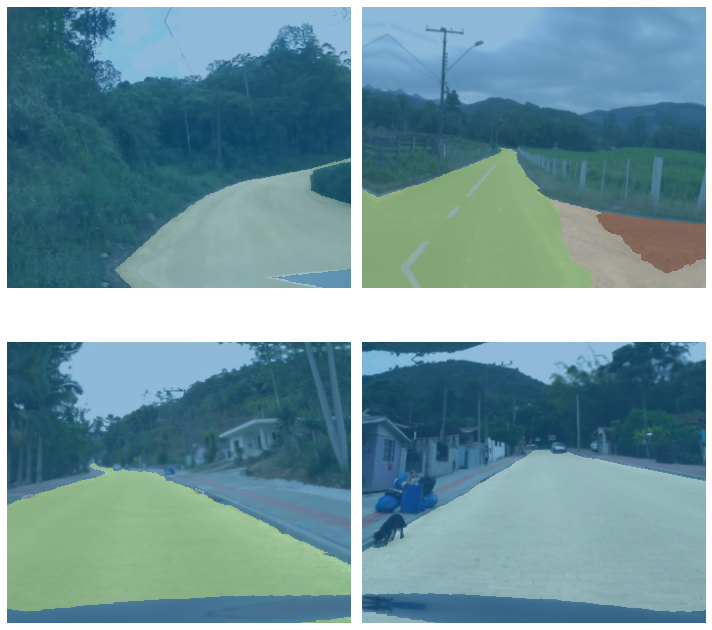

In [ ]:
data.show_batch(2, figsize=(10,10))

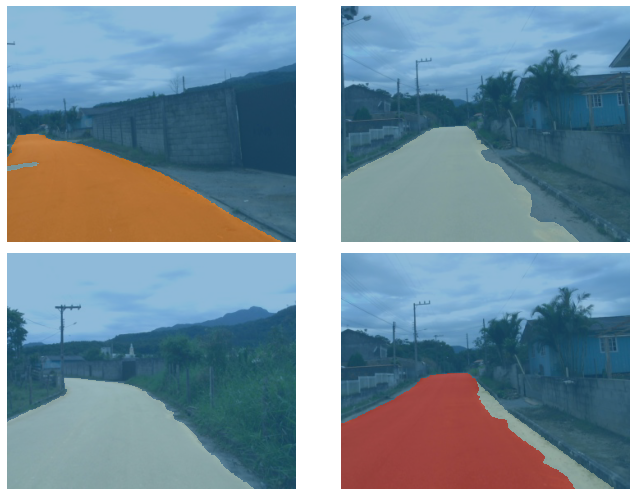

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### 4.2. Second step Model

---



In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['manholeCover']

def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_rtk
wd=1e-2

In [ ]:
balanced_loss = CrossEntropyFlat(axis=1, weight=torch.tensor([1.0,5.0,6.0,7.0,75.0,1000.0,3100.0,3300.0,0.0,270.0,2200.0,1000.0,180.0]).cuda())

In [ ]:
learn = unet_learner(data, models.resnet18, metrics=metrics, loss_func=balanced_loss, wd=wd)

In [ ]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (592 items)
x: SegmentationItemList
Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352)
y: SegmentationLabelList
ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352)
Path: /content/gdrive/My Drive/Mestrado/Segmentação/data/images;

Valid: LabelList (140 items)
x: SegmentationItemList
Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352)
y: SegmentationLabelList
ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352)
Path: /content/gdrive/My Drive/Mestrado/Segmentação/data/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, moment

In [ ]:
!/opt/bin/nvidia-smi

Sat Mar 20 23:14:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    33W /  70W |  10538MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


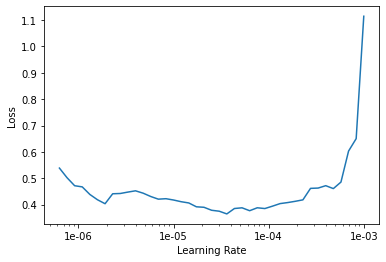

In [ ]:
#CUDA_LAUNCH_BLOCKING=1
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-4

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
learn.save('stage-1-weights')

In [ ]:
learn.load('stage-1-weights');

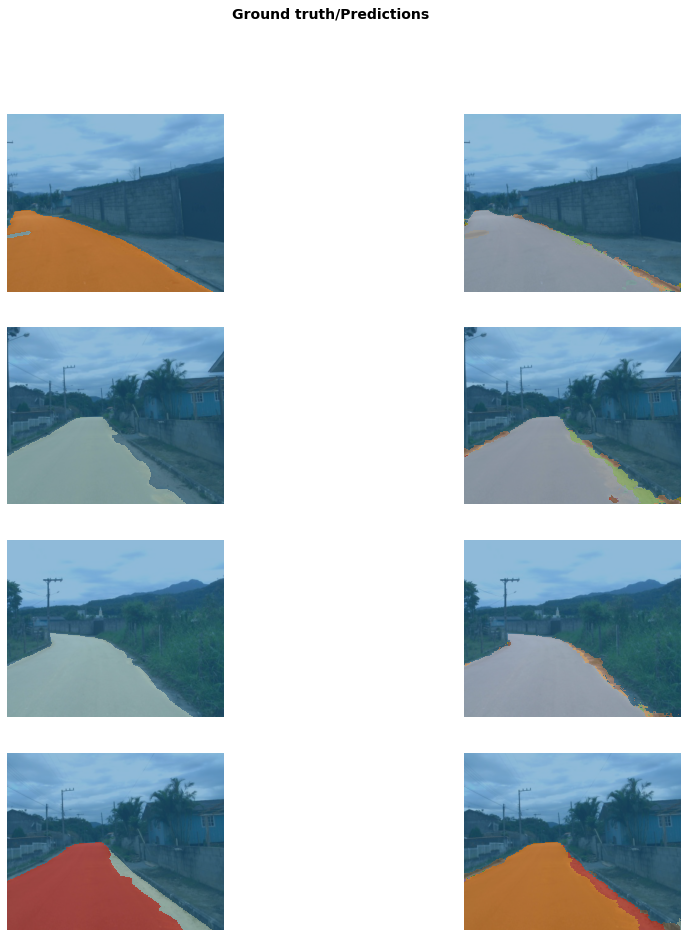

In [ ]:
learn.show_results(rows=5, figsize=(15,15))

### 4.3. Interpret

---



In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
top_losses, top_idxs = interp.top_losses((288,352))

(array([115.,  15.,   3.,   3.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.]),
 array([3.473462e-02, 3.578349e+00, 7.121963e+00, 1.066558e+01, 1.420919e+01, 1.775280e+01, 2.129642e+01, 2.484003e+01,
        2.838365e+01, 3.192726e+01, 3.547087e+01, 3.901449e+01, 4.255810e+01, 4.610172e+01, 4.964533e+01, 5.318894e+01,
        5.673256e+01, 6.027617e+01, 6.381979e+01, 6.736340e+01, 7.090701e+01], dtype=float32),
 <a list of 20 Patch objects>)

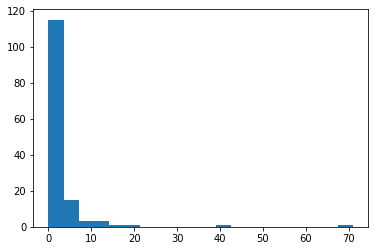

In [ ]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

In [ ]:
# top loss idxs of images
top_idxs[:5]

tensor([ 56, 115,  55, 111,  68])

### 4.4. Confusion Matrix

---



In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

((13, 13), (140, 13, 13))

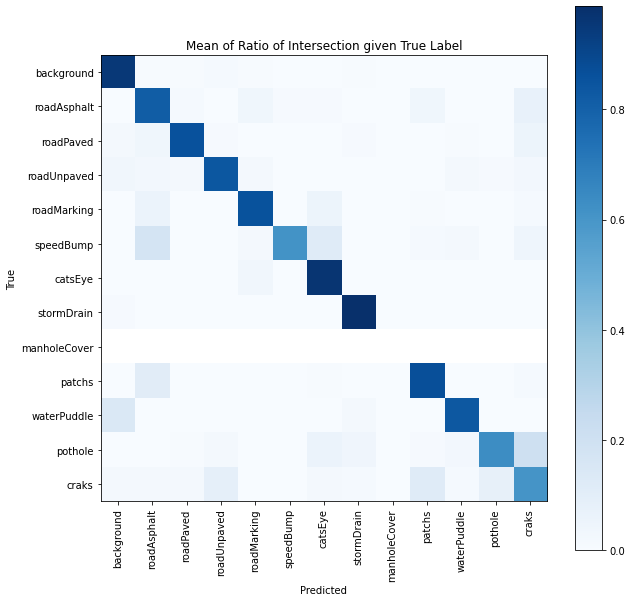

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

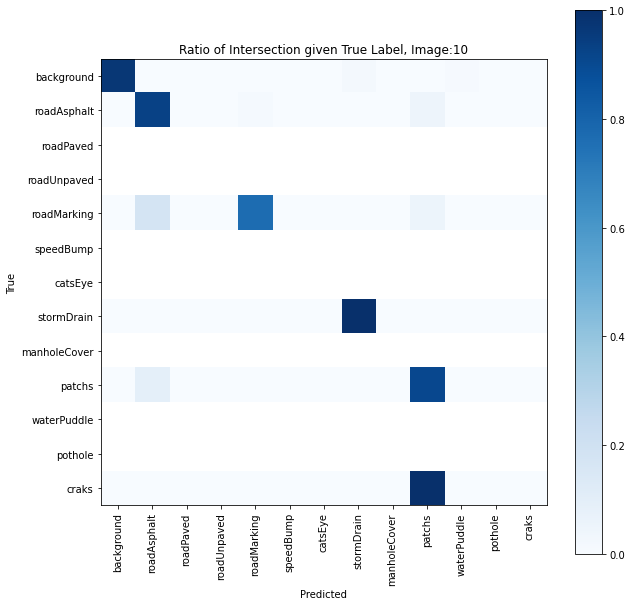

In [ ]:
# single image class performance
i = 10
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

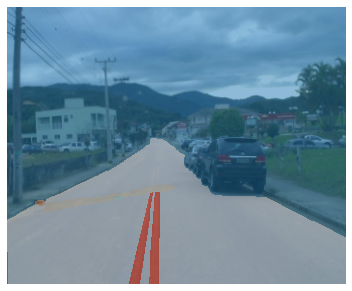

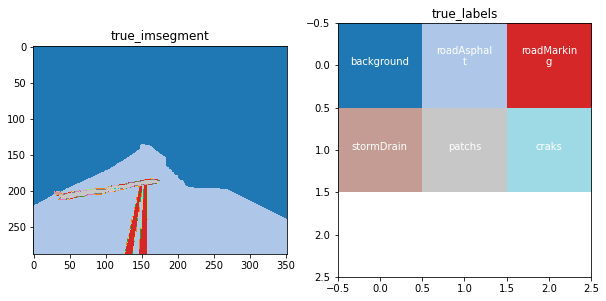

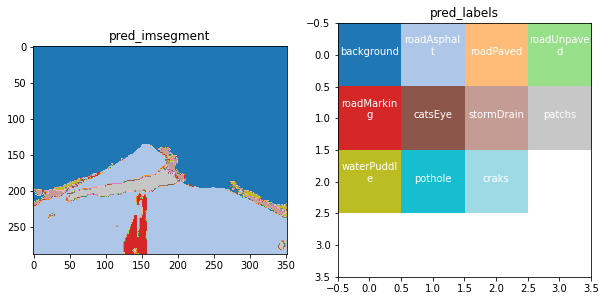

In [ ]:
# show xyz
interp.show_xyz(i)

### 4.5. Second model continuation

---



In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(100, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2-weights')

In [ ]:
learn.load('stage-2-weights');

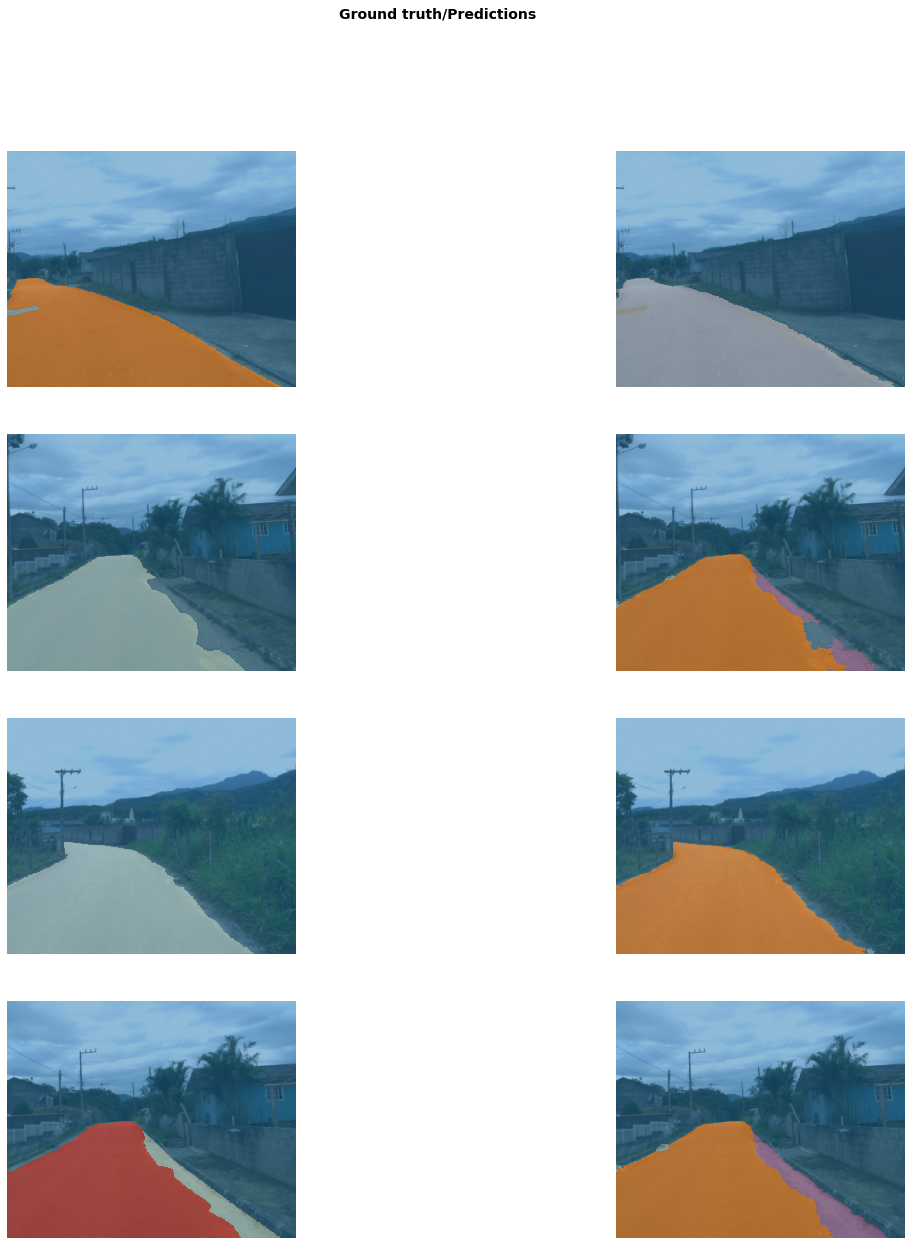

In [ ]:
learn.show_results(rows=25, figsize=(20,20))

### 4.6. Confusion Matrix

---



In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

((13, 13), (140, 13, 13))

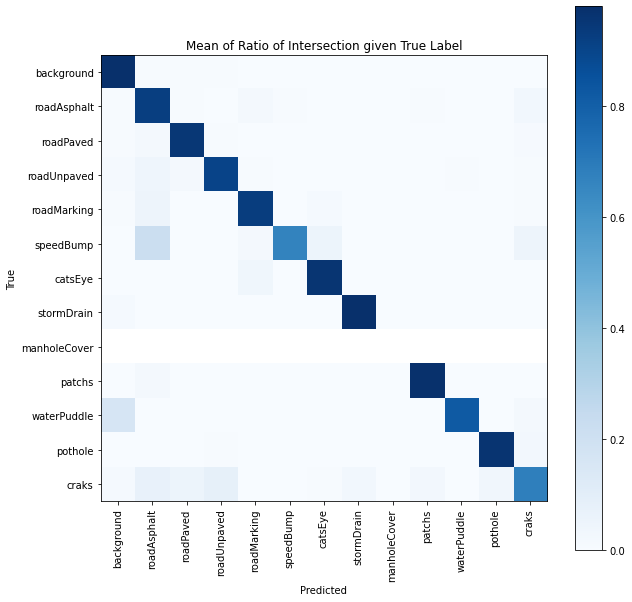

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

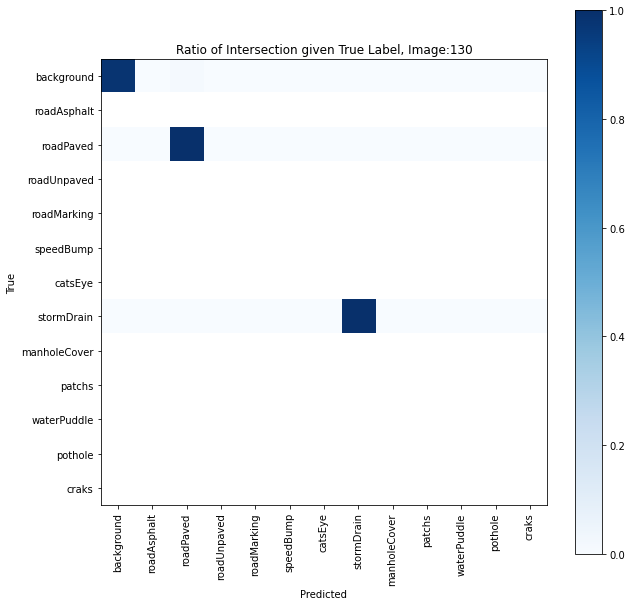

In [ ]:
# single image class performance
i = 130
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

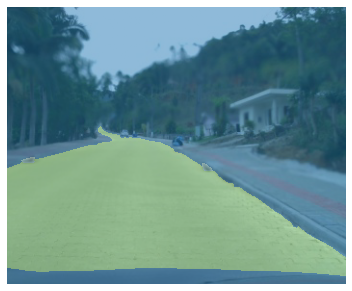

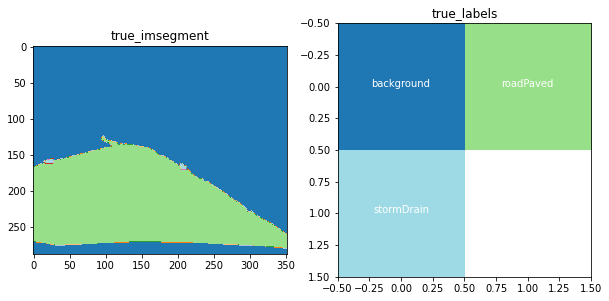

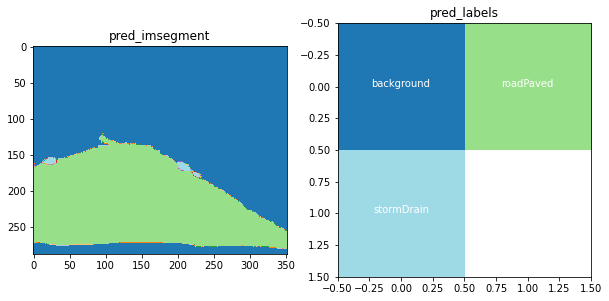

In [ ]:
# show xyz
interp.show_xyz(i)

### 4.7. Interpret

---



In [ ]:
learn.interpret

<bound method _learner_interpret of Learner(data=ImageDataBunch;

Train: LabelList (592 items)
x: SegmentationItemList
Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352)
y: SegmentationLabelList
ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352)
Path: /content/gdrive/My Drive/Mestrado/Segmentação/data/images;

Valid: LabelList (140 items)
x: SegmentationItemList
Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352),Image (3, 288, 352)
y: SegmentationLabelList
ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352),ImageSegment (1, 288, 352)
Path: /content/gdrive/My Drive/Mestrado/Segmentação/data/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1

### 4.8. Saving

---



In [ ]:
learn.save('stage-2-weights')
learn.export('/content/gdrive/My Drive/Mestrado/Segmentação/export.pkl')

## 5. Using a saved model to Predict

---



In [ ]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 4569MB of GPU RAM free


In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet18)

In [ ]:
learn.load('stage-2-weights');

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

((13, 13), (140, 13, 13))

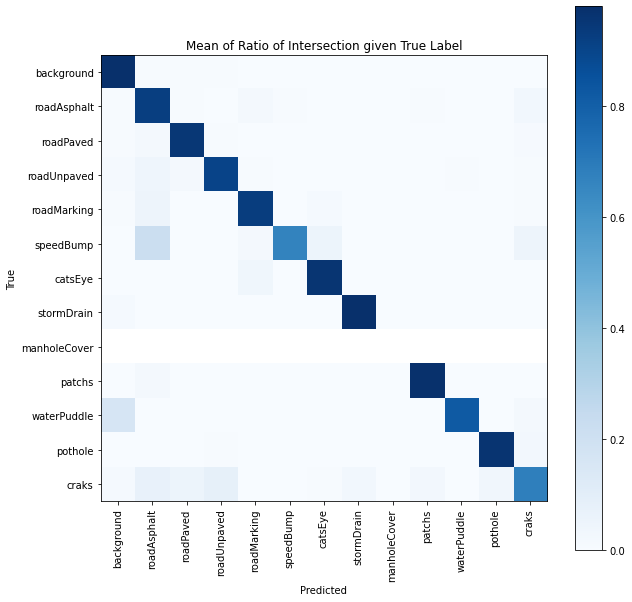

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

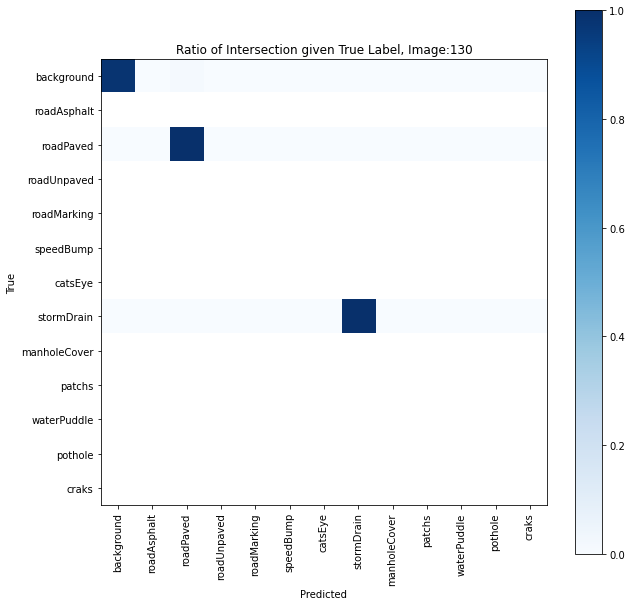

In [ ]:
# single image class performance
i = 130
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

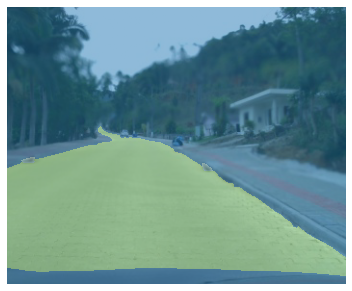

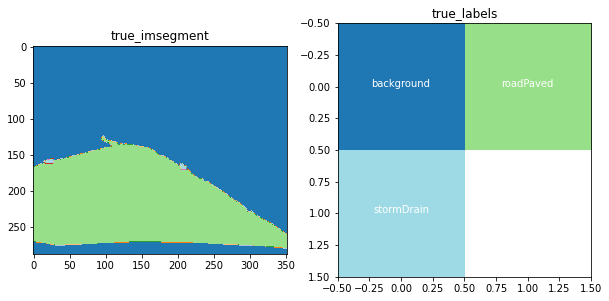

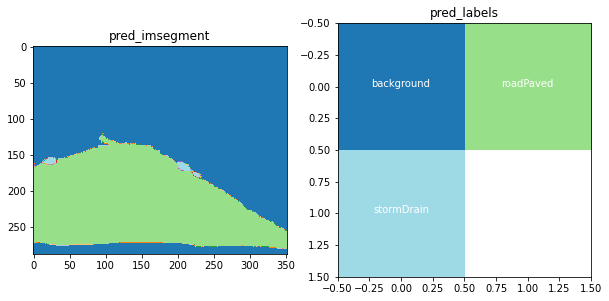

In [ ]:
# show xyz
interp.show_xyz(i)

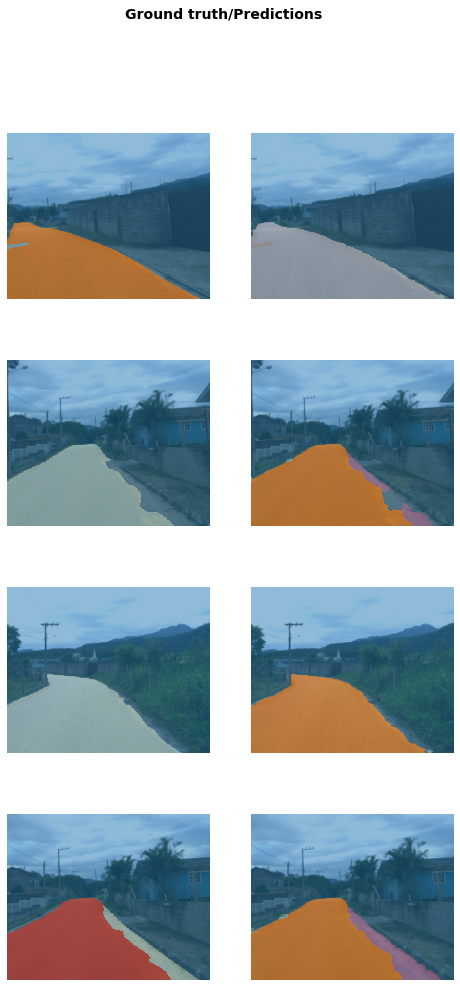

In [ ]:
learn.show_results()

## 6. Saving the Results

---



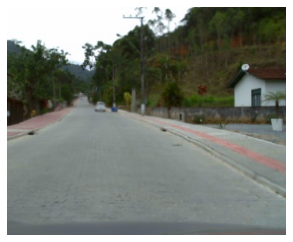

In [ ]:
img_f = fnames[655]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
import time
start = time.time()
prediction = learn.predict(img)
print(time.time() - start)

0.6809241771697998


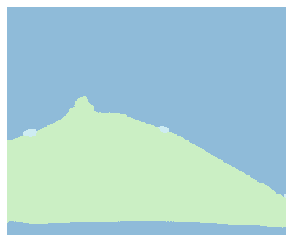

In [ ]:
prediction[0].show(figsize=(5,5))

In [ ]:
results_save = 'results'
path_rst = path/results_save
path_rst.mkdir(exist_ok=True)

In [ ]:
def save_preds(names):
    i=0
    #names = dl.dataset.items
    
    for b in names:
        img_s = fnames[i]
        img_toSave = open_image(img_s)
        img_split = f'{img_s}'
        img_split = img_split[60:]
        predictionSave = learn.predict(img_toSave)
        predictionSave[0].save(path_rst/img_split) #Save Image
        i += 1
        print(i)

In [ ]:
save_preds(fnames)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


## 7. Coloring the Results

---




In [ ]:
import os
import glob
import base64
import cv2 as cv
cv.__version__

'4.1.2'

In [ ]:
colored_results = 'results_color'
path_crst = path/colored_results
path_crst.mkdir(exist_ok=True)

In [ ]:
%load_ext cython

In [ ]:
%%cython -a
import cython
cimport numpy
import cv2 as cv
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
#def colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
cpdef numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
  # set the variable extension types
  cdef int x, y, width, height, b, g, r

  #frame = cv.imdecode(np.frombuffer(byteframe, np.uint8), -1)

  # grab the image dimensions
  width = 288
  height = 352
    
  # loop over the image, pixel by pixel
  for x in range(width):
    for y in range(height):
      b, g, r = frame[x, y]
      if (b, g, r) == (0,0,0): #background
        frame[x, y] = (0,0,0)
      elif (b, g, r) == (1,1,1): #roadAsphalt
        frame[x, y] = (85,85,255)
      elif (b, g, r) == (2,2,2): #roadPaved
        frame[x, y] = (85,170,127)
      elif (b, g, r) == (3,3,3): #roadUnpaved
        frame[x, y] = (255,170,127) 
      elif (b, g, r) == (4,4,4): #roadMarking
        frame[x, y] = (255,255,255) 
      elif (b, g, r) == (5,5,5): #speedBump
        frame[x, y] = (255,85,255)
      elif (b, g, r) == (6,6,6): #catsEye
        frame[x, y] = (255,255,127)          
      elif (b, g, r) == (7,7,7): #stormDrain
        frame[x, y] = (170,0,127) 
      elif (b, g, r) == (8,8,8): #manholeCover
        frame[x, y] = (0,255,255) 
      elif (b, g, r) == (9,9,9): #patchs
        frame[x, y] = (0,0,127) 
      elif (b, g, r) == (10,10,10): #waterPuddle
        frame[x, y] = (170,0,0)
      elif (b, g, r) == (11,11,11): #pothole
        frame[x, y] = (255,0,0)
      elif (b, g, r) == (12,12,12): #cracks
        frame[x, y] = (255,85,0)
 
  frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
  
  # return the colored image
  return frame

In [ ]:
import timeit
# Count variables
fqtd = 0

filenames = [img for img in glob.glob(str(path_rst/"*.png"))]

filenames.sort() # ADD THIS LINE

for img in filenames:
  frame = cv.imread(img)

  #%timeit colorfull_fast(frame)
  
  frame = colorfull_fast(frame)
  name = "%09d.png"%fqtd
  cv.imwrite(os.path.join(path_crst, name), frame)

  fqtd += 1
  print(fqtd)

print("Done!")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
